# TouchTerrain jupyter notebook - starter edition, running on Binder
Chris Harding, Aug. 25 , 2022 (<charding@iastate.edu>)

Warning: This is still being tested! Please report bugs to me.

- This particular notebook is meant to be run on Binder (which uses JupyterLab). 
- It is also primarily aimed at users who maybe new to Python and jupyter. It walks through the process of using TouchTerrain to create STL files for 3D printing with many small steps at a slow pace, makes few assumptions and gives more explanations.
- Hopefully this will make the much more flexible and powerful __standalone version__ of TouchTerrain accessible to many more users!

### Preparing to use Google Earth Engine online DEM rasters 

- TouchTerrain uses Digital Elevation Data (DEM)
- You can either use online elevation data or a local elevation dataset (geotiff file)
- *You don't need to go through this preparation part if you only want to use terrain data from locally stored raster files (geotiffs)*. You will get a warning about EE not being initialized properly but you can ignore that. Instead go directly to __How to run code inside a notebook__
- TouchTerrain can use DEM data from Google Earth Engine (given the corners of the area), but you need to first set up an earth engine account and create Google cloud project. Note that this includes setting up a charge account, however, you will typically not be charged. 
- See this [guide](https://github.com/ChHarding/TouchTerrain_for_CAGEO/blob/master/EarthEngine_authentication_guide.md#request-a-earthengine-dev-account) for how to get an earth engine account.


### How to run code inside a notebook

- Below is a python *code* cell.
- Run the cell  by clicking inside it and pressing Shift + Enter. Or you can hit the triangle Run button.
- You wont see any output for this cell but you'll see that the braces in `In [ ]` will show a sequential number, which means it's been run.

In [1]:
import ee # import module for earthengine-api 

### Authentication with Earth Engine
- the next cell will initiate an authorization with the earth-engine. 
- remove the leading `#` (uncomment the line) and run it. Make sure there's no space in front of ee!

<div>

- This text should appear and you should be redirected to a webpage:
```
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does  not start automatically, please manually browse the URL below.
```
- The web page will have you select a Google account for use with Earth Engine and give you a token
- Assuming you got your earth engine account, follow [this part of the guide](https://github.com/ChHarding/TouchTerrain_for_CAGEO/blob/master/EarthEngine_authentication_guide.md#generating-the-token) to get this token
- Paste in your token here: `Enter verification code: <your token>` and hit Enter, you should get `Successfully saved authorization token.`
- Important: this needs to be done only once after the binder instance was created (as it just needs to create a file). Once done, you should put the `#` back in front of ee.Authenticate() (so the line is `#ee.Authenticate()` again), so you're not running it again after you've started from top after a kernel timeout.

In [2]:
#ee.Authenticate() # authenticate your earth engine to consume DEM data from Google

### What to do when then kernel times out (quits)
- The python kernel is the underlying python interpreter that runs the python code when you execute a code cell
- When the notebook is idle for a while (maybe you're somewhere in the middle of the notebook), it seems that its kernel will time out.
- You'll see `kernel disconnected` at the bottom and `No Kernel` at the upper right. 
- This means you can't run the next code cell but have to reconnect to the kernel first
- Click on `No Kernel` at the upper right, select the Python kernel and the click on Select
- You should now be able to again execute code cells
- Sometimes however, you may have to restart the kernel instead (Top Menu - Kernel - Restart and clear outputs)
- In this case you need to again start from the top of the notebook. Note however, that you don't have to go through the authorization again if you completed it once, so make sure this line is commented out!
- Finally, if you ever get Error 405 when Starting the Kernel I'm guessing the binder instance has died due to timeout. You will need to close your current browser page and go to https://mybinder.org/v2/gh/ChHarding/TouchTerrain_for_CAGEO/HEAD?labpath=TouchTerrain_jupyter_starters_binder.ipynb again to create a new Binder instance. This will again take some time but less then the very first time (at least in my experience)
- This also means that any STL files you may have created earlier are lost, so it is important to download them right away.

### Virtual python environment 
- this is just FYI, don't worry if you don't know what conda is ...
- binder will create a virtual conda environment called *notebook* and install all the package from environment.yml in it (which takes a while)
- the first part in environment.yml ensures that geemap can run properly as apparently the install order and version matter, the rest will install all other dependencies for touchterrain
- binder will the run a shell script called postBuild, which will use pip to install the touchterrain package
- binder runs the current notebook within this *notebook* environment, so the imports below should all work

### Importing python packages
- Run the next cell, it'll import the required packages into Python, including Touchterrain
- The earth engine package you imported and authorized earlier, will be initialized here. You should see `EE init() worked with .config/earthengine/credentials`


In [3]:
# import packages
import os.path
from glob import glob
import k3d
from random import randint
from shutil import rmtree
import zipfile
from geojson import Polygon
import geemap
from touchterrain.common import TouchTerrainEarthEngine as TouchTerrain
from touchterrain.common.TouchTerrainGPX import *
args = TouchTerrain.initial_args # default args

## Define the values for processing settings
- We now need to define the processing settings for the 3D model we want to create. Unlike the web app, they need to be set via Python variables.
- The variable `args` will hold all processing settings. The __name__ of a setting  will be between [] and inside double quotes, the setting's __value__ will be to the right of the = . The value can be a number (120 or 0.4), a string ("STLb") or the special value `None`.
- Example: `args["tilewidth"] = 120`     will define the value of the setting named `tilewidth` to be 120

### Comments
- In Python, anything to the right of a `#` will be ignored.
- You will often need comment out or uncomment a line of Python code.
- A line starting with a `#` (no spaces before it) is said to be commented out, it will be entirely ignored. This a useful to temporarily deactivate the line and re-activate it again later.
- To uncomment a line means to remove the leading `#`, again leaving no spaces before the first actual code letter. This makes the line valid code again.

<div>

- Example of commenting out a line of code and uncommenting it properly:
```
print(123)
#print(123)
print(123)
```
- Examples of bad commenting with a leading space. I'm using an underscore here for better visibility.
```
_#print(123)
_print(123)
```

### Use a locally stored geotiff DEM file instead of an online DEM
__If you don't plan to use a local geotiff and instead want to use an online DEM, skip this cell and go to *Select your print area*__
- You may want create a terrain model from a geotiff DEM file that you've downloaded or created via a GIS. As TouchTerrain needs to import this file during processing, you first need to copy (upload) it via the jupyterLab File Manager.
- Open the File Manager (left side) and drag your geotiff into the panel to upload it. Remember the file name for later
- The folder called __stuff__ contains a very small example geotiff file called __pyramid.tif__. From the (root) folder this notebook is in, the path to this file is therefore __stuff/pyramid.tif__  

<div>

- The cell below sets the value of __importedDEM__ to this path (e.g. `"stuff/pyramid.tif"`). To use your geotiff file, replace this with it's name, e.g. `"myDEM.tif"` (make sure to use "s!). 
- if you do NOT want to use a local geotiff and want to use online DEM rasters instead, set the value to None. Comment/Uncomment the appropriate choice below and hit Shift-Enter
- if you are using a local geotiff, skip _Select DEM source_ and _Select print area on geemap_ as the geotiff is your DEM source and  implicitly defines the print area. Go straight to _Setting the tile width_

In [4]:
# Comment out one of following two lines:
#args["importedDEM"] =  "stuff/pyramid.tif" # path of local geotiff file to use
args["importedDEM"] = None  # no file used, use online DEM rasters instead

# convert into an absolute path for later
if args["importedDEM"] != None:
    args["importedDEM"]= os.path.abspath(args["importedDEM"]) 
    print("importedDEM", args["importedDEM"])

### Select the name of the DEM source (online elevation data)
- Before you can select the actual print area, you need to select which online DEM source will be used. The setting is called `DEM_name`.
- There are several options but for starters you only need to decide among two options:
    - If your area is in the lower 48 US states, use `USGS/NED`
    - Anywhere else on the globe use: `JAXA/ALOS/AW3D30/V2_2`
    - (there are more DEM sources to choose from, see `DEM_name` [here](https://github.com/ChHarding/TouchTerrain_for_CAGEO#processing-parameters) )
- Comment/uncomment the appropriate line in the cell below and hit Shift-Enter

In [5]:
# Comment out one of the following two lines
args["DEM_name"] = "USGS/3DEP/10m"  # area is within the lower 48 (US)
#args["DEM_name"] = "JAXA/ALOS/AW3D30/V2_2"  # area is outside the US (worldwide)

### Import GPX path lines
__This is more of an expert option. If you are just starting, skip this and go to the next cell__
- You can drape one or more gpx (path) files over your terrain
- Similar to importedDEM, the file names for the GPX file(s) are stored in the importedGPX setting.
- However, as you can import more than one GPX file, you need to put the path name into a list, i.e. inside brackets, even if you just have one GPX file. Separate multiple GPX files with a comma:  
    - `args["importedGPX"] = ["justonegpxfile.gpx"]`  
    - `args["importedGPX"] = ["file1.gpx", "file2.gpx"]`
- `gpxPathHeight` (in meters) defines how much a path is elevated above the terrain. Use a negative number to create a trench.
- `gpxPixelsBetweenPoints` (in meters) lets you reduce the number of point in your path to place a point only every X meters. This can help to simplify complex patterns.
- `gpxPathThickness` (meters) controls the thickness of the path, which makes it more pronouced when printed
- There are several GPX example files in the stuff folder. To use them, uncomment the first 4 lines in the cell below and comment out the last line.
- If you're not using GPX files, just leave the cell as is and run it. Setting importedGPX to None means that no GPX files are imported.


In [6]:
args["gpxPathHeight"] = 5
args["gpxPixelsBetweenPoints"] = 20
args["gpxPathThickness"] = 2

# Comment out one of the following two lines
#args["importedGPX"] = ["stuff/gpx-test/DLRTnML.gpx", "stuff/gpx-test/DonnerToFrog.gpx", "stuff/gpx-test/CinTwistToFrog.gpx"] # list of GPX files
args["importedGPX"] = None  # Do not use any GPX path files


## Select your print area
- When using an online DEM, there are several ways to define the area you want to print. Use only one and skip the cells for the other two options. Then go to _Setting the tile width_
- A)  Enter corner coordinates of a box into a code cell
- B)  Use your mouse to digitize a box, circle or polygon on a geemap
- C)  Load a kml file (typically created via Google Earth) that contains a single polygon


### A) Select print area via lat/long coordinates of its corners (optional)
- If you'd rather define your area through actual coordinates, change the default values in the cell below accordingly. 
- Note that you *must* give it the lat/long of the bottom left (South-West) corner and lat/long of the top right (North-East) corner!
- After you've run the cell, skip B and C and jump straight to `Setting the tile width`

In [7]:
# Bottom left corner
args["bllat"] = 39.322
args["bllon"] = -120.374

# Top right corner coordinates
args["trlat"] = 39.457
args["trlon"] = -120.2

### B) Select print area interactively via geemap
- If you didn't use a local geotiff or set your the print area's corner coordinates, run the next cell to show an interactive map, from which you will select your print area. 
- Valid areas are covered by a grey hillshade layer in the background. If your desired area is not covered, go back and select the worldwide DEM source, and re-run the next cell.
- If you're importing GPX files, they will show up on the map as cyan lines.
- To find the desired print area, use left mouse drag to pan and mouse wheel (or +- buttons) to zoom in/out.
- You can also use the search buttons (globe on top left or spyglass) which will place a marker at the result's location.

In [8]:
# Create an interactive map and center on default area
center_lat = (args["trlat"] + args["bllat"]) / 2
center_lon = (args["trlon"] + args["bllon"]) / 2
Map = geemap.Map(center=(center_lat, center_lon), zoom=7) 

# make a hillshade layer and add it to map
dem = ee.Image(args["DEM_name"]) # DEM source
hs = ee.Terrain.hillshade(dem, 315, 35) # sun azimuth and angle 
vis_params = {'min': 0,'max': 255,} # greyscale color ramp
Map.addLayer(hs, vis_params, 'hillshade', shown=True, opacity=0.5) # semi transparent overlay

# if GPX files were used, add them to the map
if args["importedGPX"] != None and len(args["importedGPX"]) > 0: 
        gpx = ee.Feature(convert_to_GeoJSON(args["importedGPX"]))
        Map.addLayer(gpx, {"color":'00FFFF', "strokeWidth":"1"}, "GPX line", opacity=0.9)

Map # makes the interactive map show up as output of this cell

Map(center=[39.3895, -120.287], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

- Once you found a good general area, hit a Draw button in the center left to digitize the exact outline of your terrain model. 
- Your options are: Draw a Polygon or Draw a Rectangle or Draw a Circle. __Do NOT use Draw a Marker or Draw a Polyline!__
- Draw a Rectangle is the simplest method.
- Note: I do not know how to edit or delete outlines. If you change your mind you can simply draw another outline on top of previous outline, which will then be used, even as the old outline is still visible. If this gets too cluttered, you can always re-run the cell above and start over with a clear slate.
- Once you're happy with your outline, run the cell below. It will store the (last) outline and use it to create your terrain model. If you change your mind, simply draw another outline and re-run the cell below, it will always take the most recent outline.
- After running the cell below, skip C

In [10]:
# make and store a GeoJSON polygon from (last) digitized outline
polyft = Map.draw_last_feature # get last outline
args["polygon"] = Polygon(polyft.getInfo()['geometry']['coordinates'])

### C) Using a KML file to define the outline of the area
- Instead of digitizing an outline in the geemap, you could instead use a polygon stored in a kml file. You can digitize a polygon in Google Earth and store it as a kml file (NOT a kmz file!). 
- In Jupyterlab click on File Browser on the right and drag your kml file into the panel to upload it
- Check that the kml file in the same folder as the notebook and set `poly_file` to its location.
- The *stuff* folder contains an example kml file

In [11]:
# Comment out either this line:
args["poly_file"] = None # Don't use a kml file

# or both of these lines:
#args["poly_file"] = "stuff/polygon_example.kml" # location of kml file to use
#args["polygon"] = None  # ensures that any gee polygon you might have digitized is not used

### Setting the tile width
- (If you used a local geotiff file as DEM, resume here)
- The tilewidth setting defines how (physically) large the selected print area will be after it's been printed. Units are in mm.
- By width, we mean the extent of you model in the East-West direction. The height will be automatically calculated based on the area you selected earlier
- Change the value in the cell below to your liking and hit Shift-Enter

In [12]:
args["tilewidth"] = 120 # in mm

### Setting the number of tiles and their and setup  
- It's possible to divide the print are into multiple tiles. This will results in several STK files instead of just one.
- This is useful if you want to print several (smaller) tiles that each fit on you buildplate and later glue them together into one large model.
- If you just want a single STL file, set both, ntilesx and ntilesy, to 1
- For multiple tiles, decide how many tiles you want along East-West (ntilesx) and how many along North-South (ntilesy)

In [13]:
args["ntilesx"] = 1 # number of tiles in x  
args["ntilesy"] = 1 # number of tiles in y    

### Setting the Base thickness (in mm)
- The basethick setting determines how much material is put beneath the thinnest part to the terrain print 
- Use a value of at least 0.5 mm, more if you want a beefier base

In [14]:
args["basethick"] = 0.6 # in mm

### Setting the print resolution
- Set this value to the diameter of you nozzle size or slightly below. 
- Tinker with this only if you know what you're doing. This setting defines how much of the fine details the STL file will contain. The detail you're realistically able to print is limited by your nozzle size. If you set setting much lower than your nozzle size, the STL file will be needlessly large, the slicer will take longer but your print will come out the same as if you had used approximately your nozzle size.
- In almost all cases, 0.4 mm will be fine for 3D printers.
- If you are using a local geofiff file, setting this to -1 will use the native resolution of the geotiff. This is typically overkill b/c of the nozzle limitation and may lead to huge models that may be too much for you system to handle!

In [15]:
args["printres"] = 0.4 # in mm

### Setting the z-scale (elevation exaggeration factor)
- To print the terrain in its "true" form (without any vertical scaling applied), set zscale to 1.0. This works well for terrain with great elevation differences, such as the Grand Canyon or Mt. Fuji
- Most other terrain usual benefits from a z-scale larger than 1. For gentle hills, use 1.5 to 2.5. For cities use 2.5 to 6. For river deltas and other low relief areas use up to 10.
- The height of your printed terrain should be at least 20 - 30 mm high to show good detail. You can check the processing log for `top min/max`, max should be least 20 - 30 mm. If this is too low, use a higher zscale and process again.
- Alternatively, you can set this to a __negative number__ which will be interpreted as the desired height of the tallest terrain point in mm. Examples:  -12.7 means "make 1/2 inch tall", -20 means "make 20 mm tall", etc.

In [16]:
args["zscale"] = 1.0 # elevation scale factor

### Set the name of your terrain model zipfile
- Once a STL file of your terrain model has been created, it will be zipped into a zipfile and copied into the tmp folder. The zipfile also contains a log file and a geotiff.
- It's often a good idea to give the zipfile a name that reflects the terrain, e.g. grand_canyon.zipfile
- Set zip_file_name to the name of your zipfile. Dot not add the .zip extension, this will be done automatically
- With Jupyterlab, right click on the zip file and choose Download from the pulldown

In [17]:
args["zip_file_name"] = "myterrain" # terrain model will be inside tmp/myterrain.zip

### Other settings
- There are several more expert settings which we will skip for now.
- If you're interested, look here: https://github.com/ChHarding/TouchTerrain_for_CAGEO#processing-parameters
- If you're interested, run the cell below to list all setting names and their values


In [18]:
for name in args:
    print(name, args[name])

DEM_name USGS/3DEP/10m
bllat 39.322
bllon -120.374
trlat 39.457
trlon -120.2
importedDEM None
printres 0.4
ntilesx 1
ntilesy 1
tilewidth 120
basethick 0.6
zscale 1.0
fileformat STLb
tile_centered False
zip_file_name myterrain
CPU_cores_to_use None
max_cells_for_memory_only 25000000
no_bottom False
bottom_image None
ignore_leq None
lower_leq None
unprojected False
only None
importedGPX None
smooth_borders True
offset_masks_lower None
fill_holes None
poly_file None
min_elev None
tilewidth_scale None
clean_diags False
bottom_elevation None
dirty_triangles: False
gpxPathHeight 5
gpxPixelsBetweenPoints 20
gpxPathThickness 2
polygon {"coordinates": [[[-117.992042, 34.28626], [-117.992042, 34.317457], [-117.929557, 34.317457], [-117.929557, 34.28626], [-117.992042, 34.28626]]], "type": "Polygon"}


## Generating the STL model file
- Running the next cell will convert the DEM (either from a local geotiff file or from a Google Earth online DEM source) into STL file and put it inside a zipfile in the tmp folder. You will also get a log file and the geotiff that was processed.
- This may take some time!
- During processing you'll see a star indicator (In[*]) and a lot of log messages. Those messages will also be in the logfile inside the zip, and may be useful later.

INFO:root:Using GeoJSON polygon for masking with 216 points
INFO:root:Log for creating 3D model tile(s) for  10m_-117.96_34.30 
 
INFO:root:DEM_name = USGS/3DEP/10m 
INFO:root:trlat = 34.33114056791964 
INFO:root:trlon = -117.9130173944765 
INFO:root:bllat = 34.26730445714291 
INFO:root:bllon = -118.01354196897316 
INFO:root:printres = 0.4 
INFO:root:ntilesx = 1 
INFO:root:ntilesy = 1 
INFO:root:tilewidth = 120 
INFO:root:basethick = 0 
INFO:root:zscale = 1.0 
INFO:root:fileformat = STLb 
INFO:root:no_bottom = False 
INFO:root:unprojected = False 
INFO:root:no_normals = True 
INFO:root:
process started: 19:07:53.674282 
INFO:root:
Region (lat/lon):
   34.33114056791964 -117.9130173944765 (top right)
   34.26730445714291 -118.01354196897316 (bottom left) 
INFO:root:center at [-117.96327968172483, 34.29922251253127], UTM11N, EPSG:32611 
    (
      way["landuse"](poly:"34.29557278337004 -118.00297248990601 34.29949229894934 -118.0113429370799 34.29958364725436 -118.01151801651818 34.2996

Log for creating 3D model tile(s) for  10m_-117.96_34.30 
 
DEM_name = USGS/3DEP/10m 
trlat = 34.33114056791964 
trlon = -117.9130173944765 
bllat = 34.26730445714291 
bllon = -118.01354196897316 
printres = 0.4 
ntilesx = 1 
ntilesy = 1 
tilewidth = 120 
basethick = 0 
zscale = 1.0 
fileformat = STLb 
no_bottom = False 
unprojected = False 
no_normals = True 

process started: 19:07:53.674282 

Region (lat/lon):
   34.33114056791964 -117.9130173944765 (top right)
   34.26730445714291 -118.01354196897316 (bottom left) 
easting: -117.96327968172483 northing: 34.29922251253127
easting: -117.96327968172483 northing: 34.29922251253127
center at [-117.96327968172483, 34.29922251253127], UTM11N, EPSG:32611 


INFO:root:lon/lat size in degrees: [0.10052457449666008, 0.06383611077672668] 
INFO:root:Earth Engine raster: USGS/3DEP/10m 


lon/lat size in degrees: [0.10052457449666008, 0.06383611077672668] 
requesting 30.84749450724196 m resolution from EarthEngine
Earth Engine raster: USGS/3DEP/10m 


INFO:root:URL for geotiff is:  https://earthengine.googleapis.com/v1/projects/579068275138/thumbnails/23c6316dcd7273a3aa0a7140b67e0dfb-beea7eab315e2e03322d95db628e6fa0:getPixels 


URL for geotiff is:  https://earthengine.googleapis.com/v1/projects/579068275138/thumbnails/23c6316dcd7273a3aa0a7140b67e0dfb-beea7eab315e2e03322d95db628e6fa0:getPixels 


INFO:root: geotiff size: 0.16548728942871094 Mb 
INFO:root: cell size 30.84749450724196 m, upper left corner (x/y):  406816.757561507 3799208.2710064272 
INFO:root:omitting cells with elevation < -16384 
INFO:root:full (untiled) raster (height,width)  (224, 295) float64 elev. min/max: 866.6945190429688 2364.873291015625 
INFO:root:cell size: 30.84749450724196 m  
INFO:root:adjusted print res from the requested 0.4 mm to 0.4067796610169492 mm to ensure correct model dimensions 
INFO:root:total model size in mm: 120 x 91.11864406779661 
INFO:root:map scale is 1 : 75833.42399696982 


 geotiff size: 0.16548728942871094 Mb 
 cell size 30.84749450724196 m, upper left corner (x/y):  406816.757561507 3799208.2710064272 
omitting cells with elevation < -16384 
full (untiled) raster (height,width)  (224, 295) float64 elev. min/max: 866.6945190429688 2364.873291015625 
cell size: 30.84749450724196 m  
adjusted print res from the requested 0.4 mm to 0.4067796610169492 mm to ensure correct model dimensions 
total model size in mm: 120 x 91.11864406779661 
map scale is 1 : 75833.42399696982 
elev min/max : 866.69 to 2364.87


DEM plot and histogram saved as tmp/USGS-3DEP-10m_elevation_plot_with_histogram.png
INFO:root:Cells per tile (x/y) 295 x 224 
INFO:root:using single-core only (multi-core is currently broken :( 
Writing tile into memory buffer
creating internal triangle data structure for <_MainProcess name='MainProcess' parent=None started>
10 % <_MainProcess name='MainProcess' parent=None started>


Cells per tile (x/y) 295 x 224 
using single-core only (multi-core is currently broken :( 
top min/max for tile (mm): 0.6 20.356179966666428


20 % <_MainProcess name='MainProcess' parent=None started>
30 % <_MainProcess name='MainProcess' parent=None started>
40 % <_MainProcess name='MainProcess' parent=None started>
50 % <_MainProcess name='MainProcess' parent=None started>
60 % <_MainProcess name='MainProcess' parent=None started>
70 % <_MainProcess name='MainProcess' parent=None started>
80 % <_MainProcess name='MainProcess' parent=None started>
90 % <_MainProcess name='MainProcess' parent=None started>
100% <_MainProcess name='MainProcess' parent=None started> 

tile 1 1 STLb 9.638484954833984 Mb 
INFO:root:
1 x 1 tiles, tile size 120.00 x 91.12 mm
 
INFO:root:tile 1 1 : height:  0.6 - 20.356179966666428 mm , file size: 10 Mb 
INFO:root:
total size for all tiles: 9.6 Mb 
INFO:root:added full geotiff as 10m_-117.96_34.30.tif 
INFO:root:added histogram of elevation values as 10m_-117.96_34.30_DEMandHistogram.png 
INFO:root:
processing finished: 19:08:08.921373 



1 x 1 tiles, tile size 120.00 x 91.12 mm
 
tile 1 1 : height:  0.6 - 20.356179966666428 mm , file size: 10 Mb 

total size for all tiles: 9.6 Mb 
zip finished: 19:08:08.918800
added full geotiff as 10m_-117.96_34.30.tif 
added histogram of elevation values as 10m_-117.96_34.30_DEMandHistogram.png 

processing finished: 19:08:08.921373 
Wrote coloured OBJ to tmp/obj_export.obj
Created zip file tmp/myterrain.zip 9.80 Mb


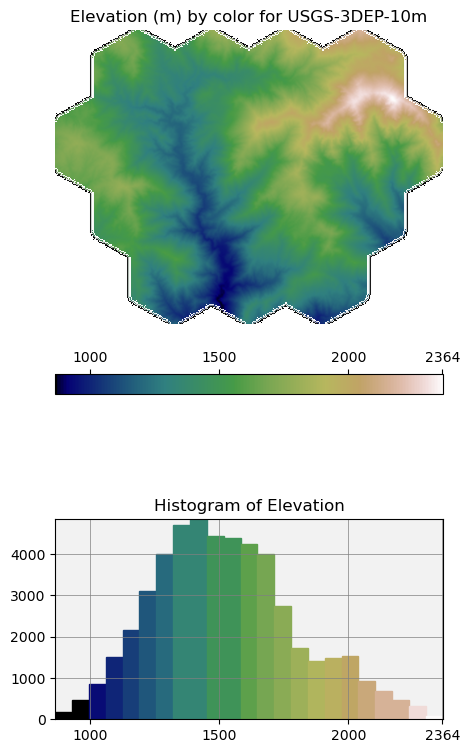

In [19]:
# create zipfile under tmp with the STL file of the terrain model
totalsize, full_zip_file_name = TouchTerrain.get_zipped_tiles(**args) 
print("Created zip file", full_zip_file_name,  "%.2f" % totalsize, "Mb")

## Preview the model
- run the cell below to get a 3D Preview of the model. If you have multiple tiles they will have different colors.

In [20]:
# unzip zif file into a folder a
folder, file = os.path.splitext(full_zip_file_name) 
zip_ref = zipfile.ZipFile(full_zip_file_name, 'r')
zip_ref.extractall(folder)
zip_ref.close()

# get all stl files (tiles) in that folder
mesh_files = glob(folder + os.sep + "*.STL")

# Create 3D plot
plot = k3d.plot()

# Add all tiles with a random color
for m in mesh_files:
    col = (randint(0,255) << 16) + (randint(0,255) << 8) + randint(0,255) # random rgb color as hex
    buf = open(m, 'rb').read()
    plot += k3d.stl(buf, color=col)
plot.display()

# remove folder
rmtree(folder)

Output()

## Final thoughts
- You can now download your zipfile from the tmp folder and unzip it to 3D print the STL file.
- It will also contain a log file and the geotiff it used to create the STL.
- Click on the *File Browser* icon on the very left to your notebook and then double-click on _tmp_
- Right-click on the zip-file and go to Download

## Long-term binder use
- I'm unclear on how long a binder instance exists when it's not being used. 
- It's quite possible that the binder binder instance won't "stay open" for longer than a couple of hours(???)
- This is not really an issue, it just means you'll have to start a new binder when you return to the browser after a while: https://mybinder.org/v2/gh/ChHarding/TouchTerrain_for_CAGEO/HEAD?labpath=TouchTerrain_jupyter_starters_binder.ipynb 
- Note that you will need to wait for the installation again and re-do your Earth Engine authentication.
- Also, the new instance will not preserve any zip files that you might have created in the old instance (or any file you uploaded), so make sure to download these right away!
- If you want to make sure that the kernel stays busy and so your instance doesn't die, you can run the cell below. It will do nothing (endless loop with a 1 second pause) but keep the kernel busy. Once you want to use other cells again you will need to interrupts the kernel first: Kernel - interrupt (ignore the error). ALso I don't know how long this will work and you should not abuse it!


In [ ]:
# endless loop
import time
while True: 
    time.sleep(1)